In [16]:
#Import dataset and libs
%matplotlib inline
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Dataset Preparation

In [17]:
#loading the dataset
wine_dataframe = pd.read_csv('modified_datatest.csv', index_col=0)

#dataset cleaning
wine_dataframe = wine_dataframe.drop('URLS', axis=1)
wine_dataframe = wine_dataframe.drop('Tranquille to Mousseux', axis=1)
wine_dataframe = wine_dataframe[wine_dataframe['Red'] != 0]
wine_dataframe = wine_dataframe.drop('Red', axis=1)

wine_dataframe['Léger to Puissant'] = wine_dataframe['Léger to Puissant'].str.replace(';', '')
wine_dataframe['Souple to Tannique'] = wine_dataframe['Souple to Tannique'].str.replace(';', '')
wine_dataframe['Sec to Moelleux'] = wine_dataframe['Sec to Moelleux'].str.replace(';', '')
wine_dataframe['Doux to Acide'] = wine_dataframe['Doux to Acide'].str.replace(';', '')
wine_dataframe['Léger to Puissant'] = wine_dataframe['Léger to Puissant'].astype(float)
wine_dataframe['Souple to Tannique'] = wine_dataframe['Souple to Tannique'].astype(float)
wine_dataframe['Sec to Moelleux'] = wine_dataframe['Sec to Moelleux'].astype(float)
wine_dataframe['Doux to Acide'] = wine_dataframe['Doux to Acide'].astype(float)
wine_dataframe = wine_dataframe.reset_index(drop=True)

wine_dataframe['Aromas'] = wine_dataframe['Aromas'].str.replace('/+', '+', regex=True)
wine_dataframe['Aromas'] = wine_dataframe['Aromas'].str.replace(',+', '+', regex=True)
wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].str.replace('/+', '+', regex=True)
wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].str.replace(',+', '+', regex=True)
wine_dataframe['Aromas'] = wine_dataframe['Aromas'].str.replace('Ã©', 'é', regex=True)
wine_dataframe['Aromas'] = wine_dataframe['Aromas'].str.replace('Ã‰', 'é', regex=True)
wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].str.replace('Ã©', 'é', regex=True)
wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].str.replace('Ã‰', 'é', regex=True)
wine_dataframe['Aromas'] = wine_dataframe['Aromas'].str.lower()
wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].str.lower()
wine_dataframe['Aromas'] = wine_dataframe['Aromas'].str.lstrip('+')
wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].str.lstrip('+')
wine_dataframe['Aromas'] = wine_dataframe['Aromas'].str.split('+')
wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].str.split('+')

wine_dataframe['Aromas'] = wine_dataframe['Aromas'].apply(lambda x: [] if isinstance(x, float) else x)
wine_dataframe['Olphactive'] = wine_dataframe['Olphactive'].apply(lambda x: [] if isinstance(x, float) else x)

In [18]:
#transformation of word lists for aromas into columns of binary variables. 
mlb = MultiLabelBinarizer()
Aromas_one_hot_encoded = mlb.fit_transform(wine_dataframe['Aromas'])
Aromas_df_encoded = pd.DataFrame(Aromas_one_hot_encoded, columns=mlb.classes_)
Olphactive_one_hot_encoded = mlb.fit_transform(wine_dataframe['Olphactive'])
Olphactive_df_encoded = pd.DataFrame(Olphactive_one_hot_encoded, columns=mlb.classes_)
df_concatenated_0 = pd.concat([wine_dataframe, Aromas_df_encoded], axis=1)
df_concatenated = pd.concat([df_concatenated_0, Olphactive_df_encoded], axis=1)

df_concatenated.drop('Aromas', axis=1, inplace=True)
df_concatenated.drop('Olphactive', axis=1, inplace=True)

In [19]:
#remove the observations for which all continuous values are missing
mask = (df_concatenated['Léger to Puissant'] != 0) | (df_concatenated['Souple to Tannique'] != 0) | (df_concatenated['Sec to Moelleux'] != 0) | (df_concatenated['Doux to Acide'] != 0)
df_concatenated = df_concatenated[mask]

# Datset Split

In [20]:
#Split the varieties and the parameters
X = df_concatenated.drop('Cépages', axis=1)
y = df_concatenated['Cépages']

#Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state=42)

# Prediction

In [9]:
#Selection of model parameters
classifier = SVC(C=100.0, kernel='rbf', degree=3, gamma='auto')

#Train the model on train dataset
classifier.fit(X_train, y_train)

#Predict varieties of test dataset
y_pred = classifier.predict(X_test)

#Print the results
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

Cabernet-Sauvignon       0.90      0.93      0.91       460
            Malbec       0.85      0.89      0.87       127
            Merlot       0.88      0.84      0.86       214
        Pinot noir       0.98      0.96      0.97       596
        Sangiovese       0.83      0.85      0.84        65
         Zinfandel       0.86      0.86      0.86        88

          accuracy                           0.92      1550
         macro avg       0.89      0.89      0.89      1550
      weighted avg       0.92      0.92      0.92      1550



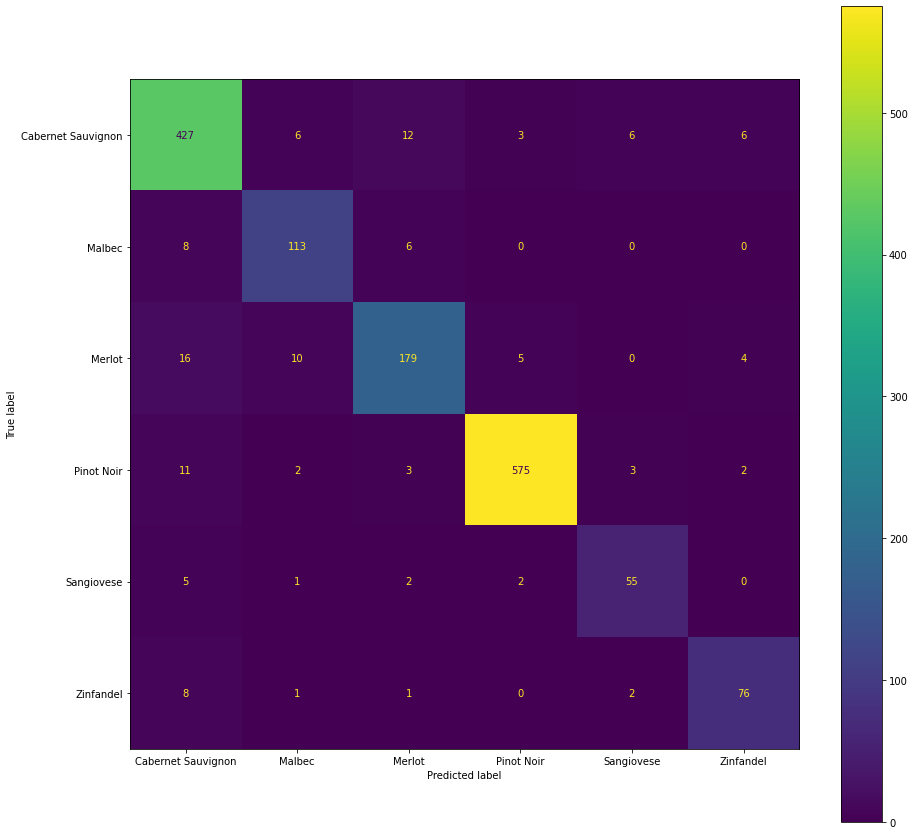

In [25]:
#Creation of a confusion matrix
fig, ax = plt.subplots(figsize=(15, 15))
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["Cabernet Sauvignon", "Malbec","Merlot","Pinot Noir","Sangiovese","Zinfandel"])
cm_display.plot(ax=ax)
plt.savefig('wine_confusion_matrix.png', dpi=300)
plt.show()

# GridSearch

In [10]:
#Optimize model parameters
svm_model = SVC()
param_grid = {'C': [1, 10, 50, 100, 150], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'gamma': ['auto', 'scale']}
grid_search = GridSearchCV(svm_model, param_grid, cv=5, verbose = 4, scoring='accuracy')
grid_search.fit(X_train, y_train)

In [12]:
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best hyperparameters:  {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Best score:  0.9277159030986125
